In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [15]:
UEFA_COEFFS = {
    "epl": 26.821,
    "laliga": 23.250,
    "seriea": 21.187,
    "bundesliga": 18.421,
    "ligue1": 16.857,
    "eredivisie": 15.250
}

In [2]:
df = pd.read_csv("final_data.csv")
df.head(2)

,Unnamed: 0,Name,League,Goals,Assists,Non-Penalty Goals,xG: Expected Goals,npxG: Non-Penalty xG,xAG: Exp. Assisted Goals,Progressive Carries,...,Shot-Creating Actions,Goal-Creating Actions,Shots on Target.1,Touches (Att 3rd),Touches (Att Pen),Age,Market Value,Starting Eleven,Minutes,Goal Involvement
0,0,Abdallah Sima,ligue1,0.50,0.11,0.50,0.43,0.43,0.09,2.74,...,2.18,0.28,1.06,19.13,4.98,23.0,10.0,45.0,42.0,17.0
1,1,Abde Ezzalzouli,laliga,0.05,0.10,0.05,0.46,0.38,0.09,5.37,...,3.07,0.34,1.20,27.14,7.14,23.0,12.0,63.0,59.0,9.0


In [3]:
df.drop(columns=["Unnamed: 0"], axis=1, inplace=True)
df = df.dropna(how='any')

In [4]:
df = df[df["Minutes"]>30]


In [24]:
most_expensive_players = df.sort_values(ascending=False, by="Market Value")
print(most_expensive_players[['Name', 'League','Age','Market Value']].head(10))

                 Name      League   Age  Market Value
208    Erling Haaland         epl  24.0         200.0
675   Vinicius Junior      laliga  24.0         200.0
394      Lamine Yamal      laliga  17.0         180.0
391     Kylian Mbappe      laliga  26.0         170.0
117       Bukayo Saka         epl  23.0         150.0
233     Florian Wirtz  bundesliga  21.0         140.0
556        Phil Foden         epl  24.0         130.0
31     Alexander Isak         epl  25.0         100.0
592           Rodrygo      laliga  24.0         100.0
397  Lautaro Martinez      seriea  27.0          95.0


In [25]:
top_xG = df.sort_values(ascending=False, by="xG: Expected Goals")
print(top_xG[['Name', 'League', 'Market Value', 'xG: Expected Goals']].head(10))

                 Name      League  Market Value  xG: Expected Goals
265     Goncalo Ramos      ligue1          45.0                1.04
208    Erling Haaland         epl         200.0                0.88
273        Harry Kane  bundesliga          90.0                0.83
620   Serhou Guirassy  bundesliga          40.0                0.81
434     Marco Asensio         epl          20.0                0.77
538   Ousmane Dembele      ligue1          75.0                0.75
672   Victor Boniface  bundesliga          45.0                0.75
442  Marko Arnautovic      seriea           3.5                0.72
391     Kylian Mbappe      laliga         170.0                0.71
499       Myron Boadu  bundesliga           7.0                0.71


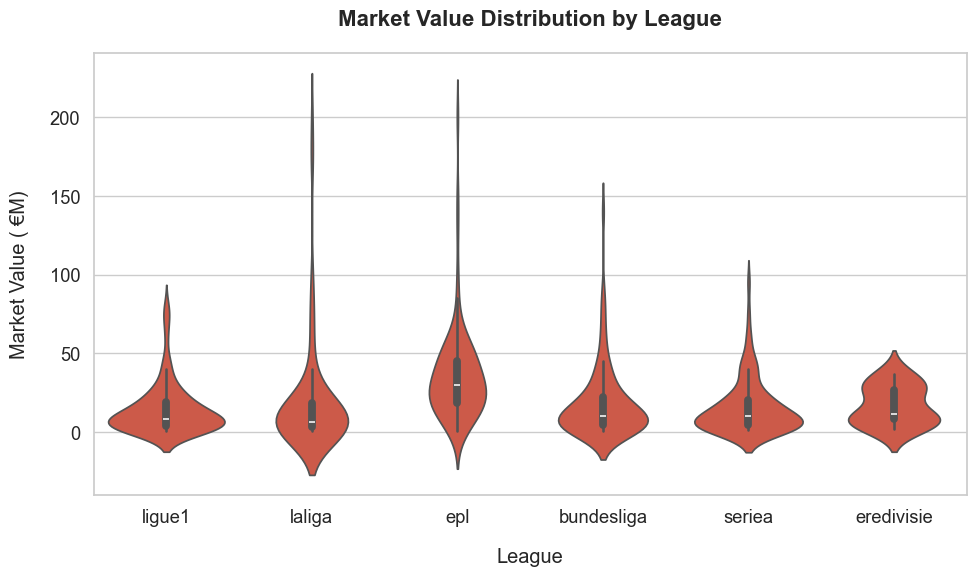

In [ ]:
plt.style.use('ggplot')
sns.set_context("notebook", font_scale=1.2)
sns.set_style("whitegrid")

plt.figure(figsize=(10, 6))
sns.violinplot(x='League', y='Market Value', data=df)

plt.title('Market Value Distribution by League', fontsize=16, weight='bold', pad=20)
plt.xlabel('League', labelpad=15)
plt.ylabel('Market Value (€M)', labelpad=15)
# plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

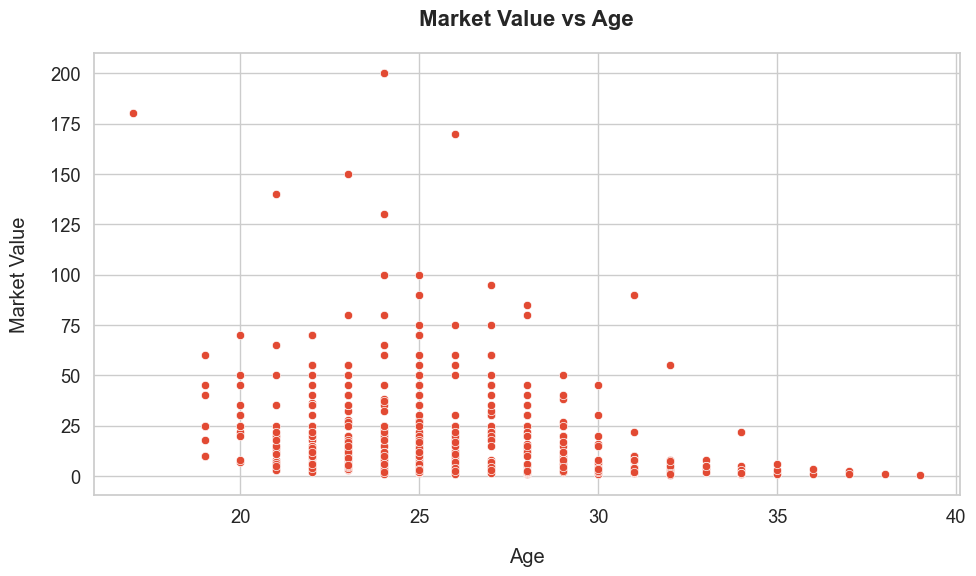

In [12]:
# Set style
plt.style.use('ggplot')
sns.set_context("notebook", font_scale=1.2)
sns.set_style("whitegrid")

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Age', y='Market Value', data=df)

# Enhancements
plt.title('Market Value vs Age', fontsize=16, weight='bold', pad=20)
plt.xlabel('Age', labelpad=15)
plt.ylabel('Market Value', labelpad=15)
plt.tight_layout()
plt.show()


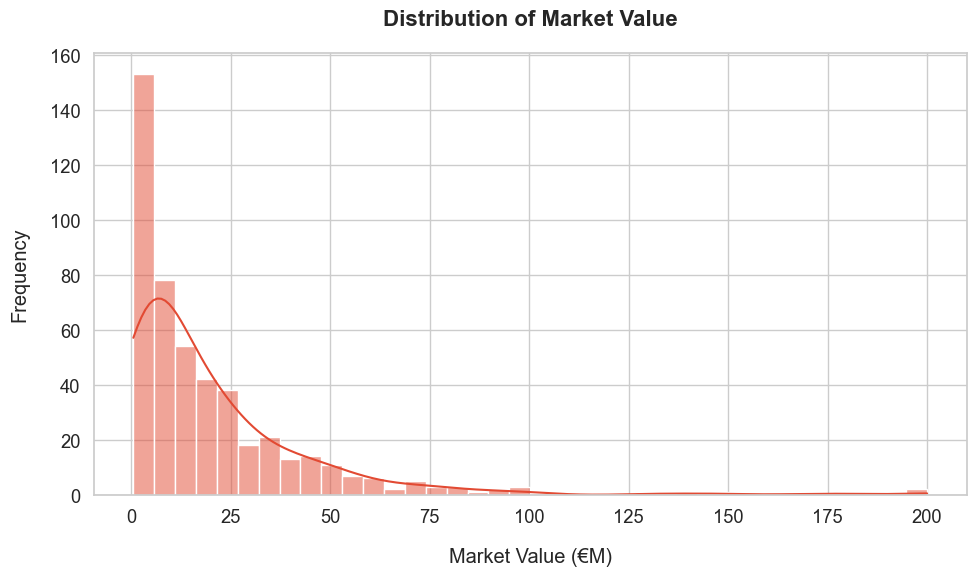

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Market Value'], kde=True)

# Enhancements
plt.title('Distribution of Market Value', fontsize=16, weight='bold', pad=20)
plt.xlabel('Market Value (€M)', labelpad=15)
plt.ylabel('Frequency', labelpad=15)
plt.tight_layout()
plt.show()

In [16]:
df["Goals-xG"] = df["Goals"] - df["xG: Expected Goals"]

In [17]:
scaler = MinMaxScaler()
coefficients = list(UEFA_COEFFS.values())
normalized_coeffs = scaler.fit_transform(np.array(coefficients).reshape(-1,1)).flatten()
league_strength_normalized = dict(zip(UEFA_COEFFS.keys(), normalized_coeffs))
df['League_Strength'] = df['League'].map(league_strength_normalized)

In [19]:
df['Log_Market_Value'] = np.log(df['Market Value'])

In [20]:
X = df[['Goals-xG','xG: Expected Goals','Goal-Creating Actions', 'Age', 'Minutes', 'League_Strength', 
        'Progressive Passes', 'Touches (Att Pen)', 
        # 'isPl',
        # 'Pl_X_League'
        ]]
y = df['Log_Market_Value']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       Log_Market_Value   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     111.3
Date:                Wed, 07 May 2025   Prob (F-statistic):          1.36e-103
Time:                        13:05:30   Log-Likelihood:                -518.72
No. Observations:                 481   AIC:                             1055.
Df Residuals:                     472   BIC:                             1093.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     2.60

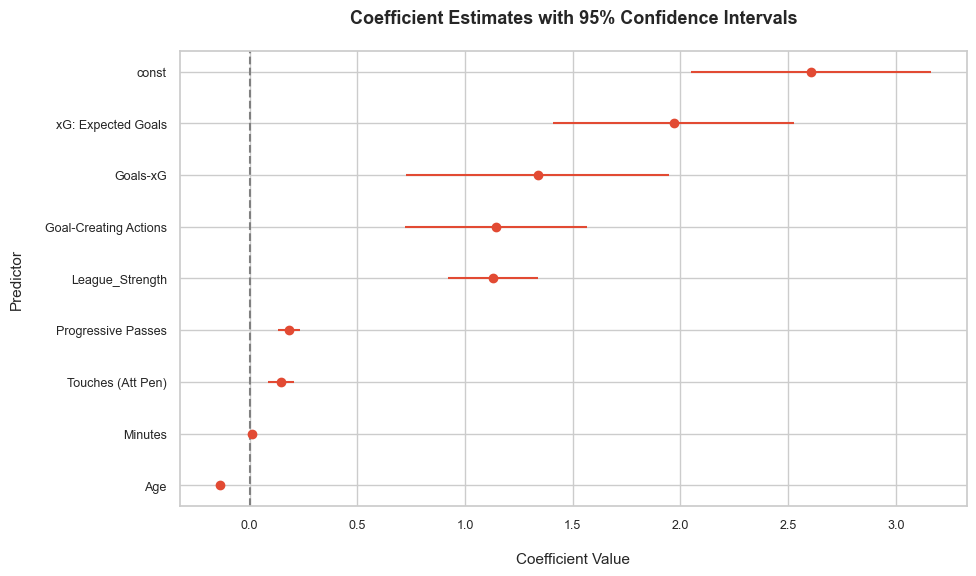

In [40]:
# Assuming 'model' is your fitted OLS model
coefficients = model.params
conf = model.conf_int()
conf['Coefficient'] = coefficients
conf.columns = ['Lower CI', 'Upper CI', 'Coefficient']
conf = conf.sort_values(by='Coefficient')

# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(conf['Coefficient'], conf.index, 
             xerr=(conf['Coefficient'] - conf['Lower CI'], conf['Upper CI'] - conf['Coefficient']), 
             fmt='o')
plt.axvline(x=0, color='grey', linestyle='--')
plt.title('Coefficient Estimates with 95% Confidence Intervals', fontsize=13, weight='bold', pad=20)
plt.xlabel('Coefficient Value', labelpad=15, fontsize=11)
plt.ylabel('Predictor', labelpad=15, fontsize=11)
plt.xticks(fontsize=9) # Reduced x-ticks fontsize
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()

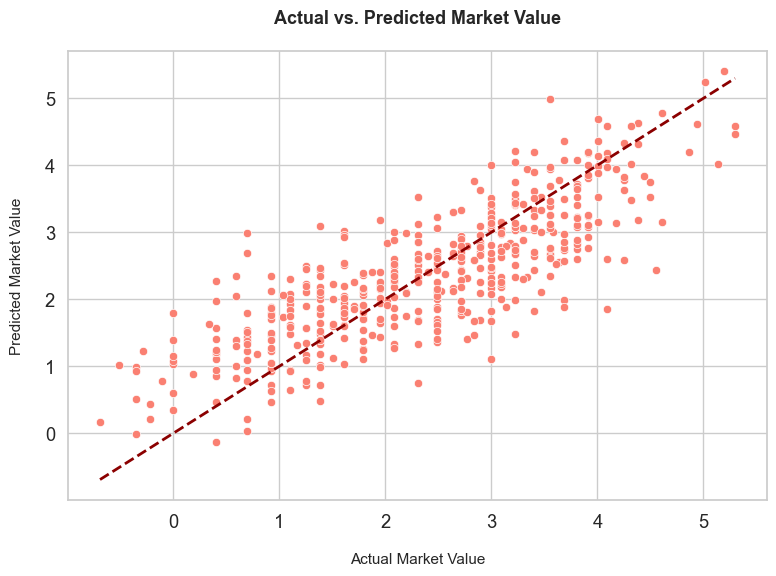

In [37]:
y_pred = model.fittedvalues

plt.figure(figsize=(8, 6))
y = df['Log_Market_Value']
sns.scatterplot(x=y, y=y_pred, color='salmon')
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='darkred', linestyle='--', linewidth=2)  # ideal fit line
plt.xlabel("Actual Market Value", labelpad=15, fontsize=11)
plt.ylabel("Predicted Market Value", labelpad=15, fontsize=11)
plt.title("Actual vs. Predicted Market Value", fontsize=13, weight='bold', pad=20)
plt.tight_layout()

plt.show()